In [1]:
import sys

%pip install -q -U gymnasium
%pip install -q -U gymnasium[classic_control,box2d,atari,accept-rom-license]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 23.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 52.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 18.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 67.2 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for box2d-py
  Running setup.py install for box2d-py ... done
  DEPRECATION: 

In [2]:
from pathlib import Path
import numpy as np
import sklearn
import tensorflow as tf
from tensorflow import keras
import gymnasium as gym
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns

# Make notebook output stable across runs
random_state = 1000
np.random.seed(random_state)
tf.random.set_seed(random_state)

# Plot settings
%matplotlib inline
sns.set()
mpl.rc('font', size=14)
mpl.rc('axes', labelsize=14, titlesize=14)
mpl.rc('legend', fontsize=14)
mpl.rc('xtick', labelsize=10)
mpl.rc('ytick', labelsize=10)
mpl.rc('animation', html='jshtml')

In [3]:
def plot_environment(env, figsize=(5, 4)):
    plt.figure(figsize=figsize)
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    return img


def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch


def plot_animation(frames, repeat=False, interval=100):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(fig, update_scene, fargs=(frames, patch),
                                   frames=len(frames), repeat=repeat, 
                                   interval=interval)
    plt.close()
    return anim    

In [10]:
# from documentation
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True, render_mode='rgb_array')
obs, info = env.reset(seed=random_state)
# intitial state is 0,0
obs

0

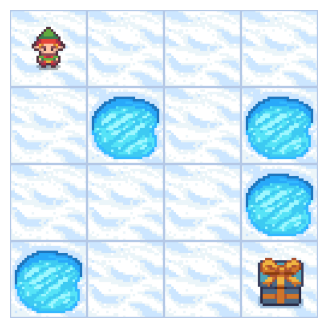

In [13]:
plot_environment(env)
plt.show()

In [8]:
# 0: Move left
# 1: Move down
# 2: Move right
# 3: Move up

env.action_space

Discrete(4)

In [14]:
# random movement
def random_movement(obs):
  return np.random.randint(0, 4)

In [18]:
# Run 1,000 episodes to see how the policy performs
num_episodes = 100
max_steps_per_episode = 500

rd_episode_rewards = []
for episode in range(num_episodes):
    obs, info = env.reset()
    
    cumulative_reward = 0
    for step in range(max_steps_per_episode):
        action = random_movement(obs)
        obs, reward, done, truncated, info = env.step(action)
        cumulative_reward += reward
        if done:
            break
    
    rd_episode_rewards.append(cumulative_reward)

In [22]:
# Calculate the mean and standard deviation of the per-episode rewards
print(f'Reward mean:   {np.mean(rd_episode_rewards):.3f}')
print(f'Reward stdev:  {np.std(rd_episode_rewards):.3f}')

# Calculate the min and max of the per-episode rewards
print(f'Reward min:    {np.min(rd_episode_rewards):.3f}')
print(f'Reward max:    {np.max(rd_episode_rewards):.3f}')

Reward mean:   0.010
Reward stdev:  0.099
Reward min:    0.000
Reward max:    1.000


In [15]:
# always move right, if not possible move down
def always_right(obs):
  if obs % 4 != 3:
    return 1 # move down 
  else:
    return 2 # move right

In [20]:
# Run 1,000 episodes to see how the policy performs
num_episodes = 100
max_steps_per_episode = 500

ar_episode_rewards = []
for episode in range(num_episodes):
    obs, info = env.reset()
    
    cumulative_reward = 0
    for step in range(max_steps_per_episode):
        action = always_right(obs)
        obs, reward, done, truncated, info = env.step(action)
        cumulative_reward += reward
        if done:
            break
    
    ar_episode_rewards.append(cumulative_reward)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
# Calculate the mean and standard deviation of the per-episode rewards
print(f'Reward mean:   {np.mean(ar_episode_rewards):.3f}')
print(f'Reward stdev:  {np.std(ar_episode_rewards):.3f}')

# Calculate the min and max of the per-episode rewards
print(f'Reward min:    {np.min(ar_episode_rewards):.3f}')
print(f'Reward max:    {np.max(ar_episode_rewards):.3f}')

Reward mean:   0.050
Reward stdev:  0.218
Reward min:    0.000
Reward max:    1.000


**Question 1.** The second policy, namely "always right, or down if not possible" performs better than the random movement policy. The simple reason here is that the random policy moves in a random manner, which means it does not acknowledge the constraints of the Frozen Lake board. While the always right policy is very simple, it does take into account the fact that the board only exists from position 0 (0 % 4 == 0) and position 3 (3 % 4 == 3). Additionally, the better-performing policy takes into account the fact that the final space is located in the bottom right square, since there are only 16 active states on the board, and the board will stop at the final state on the board. All in all, the better-defined policy (always right) has a lower probability of failing than the random choice policy. 



---



**Question 2.** Response from Google Bard:

Google Image Search is a great example of a product that employs machine learning algorithms. It uses a variety of algorithms to identify and classify images, and to rank them in order of relevance to a user's search query.

Here are some of the machine learning algorithms that Google Image Search uses:

Classification algorithms: These algorithms are used to identify the objects in an image. For example, a classification algorithm might identify that an image contains a cat, a dog, or a person.
Clustering algorithms: These algorithms are used to group similar images together. For example, a clustering algorithm might group together all of the images that contain cats, or all of the images that contain dogs.
Retrieval algorithms: These algorithms are used to find images that match a user's search query. For example, a retrieval algorithm might find all of the images that contain a cat, or all of the images that contain a dog.
Google Image Search uses a variety of training data, including images that have been manually tagged by users, images that have been labeled by experts, and images that have been automatically tagged by Google Image Search. Google Image Search is constantly being improved by training on new data and by developing new machine learning algorithms.

I have found Google Image Search to be very accurate in my own use. It has correctly identified the objects in my images, and it has returned relevant results for my search queries. I would rate the performance of Google Image Search as very accurate.

Here are some specific examples of how Google Image Search has used machine learning to improve my experience:

Google Image Search has correctly identified the objects in my images, even when they are partially obscured or in low quality.
Google Image Search has returned relevant results for my search queries, even when they are vague or open-ended.
Google Image Search has helped me to find images that I would not have found otherwise, such as images of rare or obscure objects.
Overall, I have been very impressed with the performance of Google Image Search. It is a great tool for finding images, and it uses machine learning in a way that is both helpful and invisible.

**My response**

To better answer this question, I took the answer from Google Bard and input it into ChatGPT. ChatGPT concluded that the response provided by Google Bard was an exemplary response and explanation to the prompt provided.

When provided with the answer I provided for Q3 of Problem Set 4, ChatGPT deemed that Bard's response was better than mine because it was able to provide more detail in its response and was more concentrated on the prompt.

Overall, I agree with ChatGPT's assessment of the two responses. Bard's response to the question was a lot more clear and concise than my response. Additionally, Bard explained how different ML algos could be used to power Google's image search feature. Additionally, Bard provides a more comprehensive assessment of how the performance of the ML model can be assessed. I was als